# Lab 7

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
December 4, 2023

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline

print('Numpy version: ', np.__version__)
print('Tensorflow version: ', tf.__version__)

Numpy version:  1.24.3
Tensorflow version:  2.13.0


In [8]:
# Load the data

DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We only require sentiment and text so we will drop the other columns.

In [10]:
df = df[['sentiment', 'text']]

df['sentiment'] = df['sentiment'].replace(4, 1)

Now we reduce the tweets from 1.6 million to 50,000 so it doesn't take forever to train.

In [44]:
# reduce size of dataset to 50,000 with equal number of positive and negative tweets
df_pos = df[df['sentiment'] == 1].sample(25000)
df_neg = df[df['sentiment'] == 0].sample(25000)
reduced_df = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)

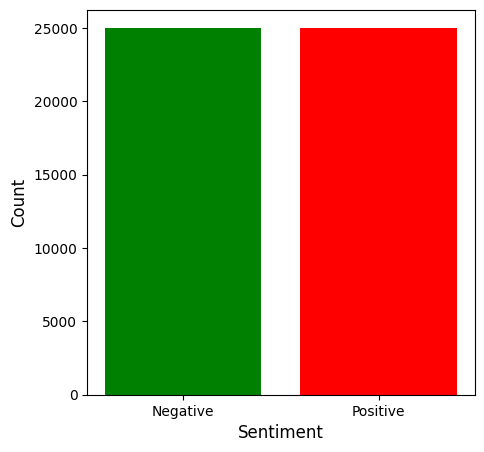

In [45]:
# plot the distribution of positive and negative sentiment

count = reduced_df['sentiment'].value_counts()
plt.figure(figsize=(5,5))
plt.bar(count.index, count.values, color=['red', 'green'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(range(len(count.index)), ['Negative', 'Positive'])
plt.show()

### Preprocessing the Test

In [28]:
# convert text to lower case
# replace urls with token
# replace user handles with token
# replace emojis with token
# replace contractions with their expansions
# remove non-alphanumeric characters
import re
import contractions

def preprocessing(tweet):
    # Convert tweet to lower case
    tweet = tweet.lower()
    
    # Replace URLs with token
    tweet = re.sub(r'http\S+|www\S+|https\S+', 'URL', tweet)
    
    # Replace user handles with token
    tweet = re.sub(r'@\w+', 'USER', tweet)

    emoji_replacements = {
        '❤️': 'HEART_EMOJI',
        '😂': 'LAUGHING_FACE_EMOJI',
        '😊': 'SMILING_FACE_EMOJI',
        '😎': 'COOL_FACE_EMOJI',
        '👍': 'THUMBS_UP_EMOJI',
        '😭': 'CRYING_EMOJI'
    }
    # Replace emojis with token (basic example)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub('EMOJI', tweet)
    
    # Replace contractions with their expansions
    tweet = contractions.fix(tweet)
    
    # Remove non-alphanumeric characters
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    
    return tweet


In [29]:
%%time
df['processed_text'] = df['text'].apply(preprocessing)

CPU times: user 12 s, sys: 133 ms, total: 12.2 s
Wall time: 12.2 s


In [33]:
# print out 10 samples of the original and processed text

for i in range(30,40):
    print('Original text: ', df['text'][i])
    print('Processed text: ', df['processed_text'][i])
    print()


Original text:  some1 hacked my account on aim  now i have to make a new one
Processed text:  some1 hacked my account on aim  now i have to make a new one

Original text:  @alielayus I want to go to promote GEAR AND GROOVE but unfornately no ride there  I may b going to the one in Anaheim in May though
Processed text:  USER i want to go to promote gear and groove but unfornately no ride there  i may b going to the one in anaheim in may though

Original text:  thought sleeping in was an option tomorrow but realizing that it now is not. evaluations in the morning and work in the afternoon! 
Processed text:  thought sleeping in was an option tomorrow but realizing that it now is not evaluations in the morning and work in the afternoon 

Original text:  @julieebaby awe i love you too!!!! 1 am here  i miss you
Processed text:  USER awe i love you too 1 am here  i miss you

Original text:  @HumpNinja I cry my asian eyes to sleep at night 
Processed text:  USER i cry my asian eyes to sleep at

In [38]:
data_pos = list(df[df['sentiment'] == 1]['processed_text'])
data_neg = list(df[df['sentiment'] == 0]['processed_text'])


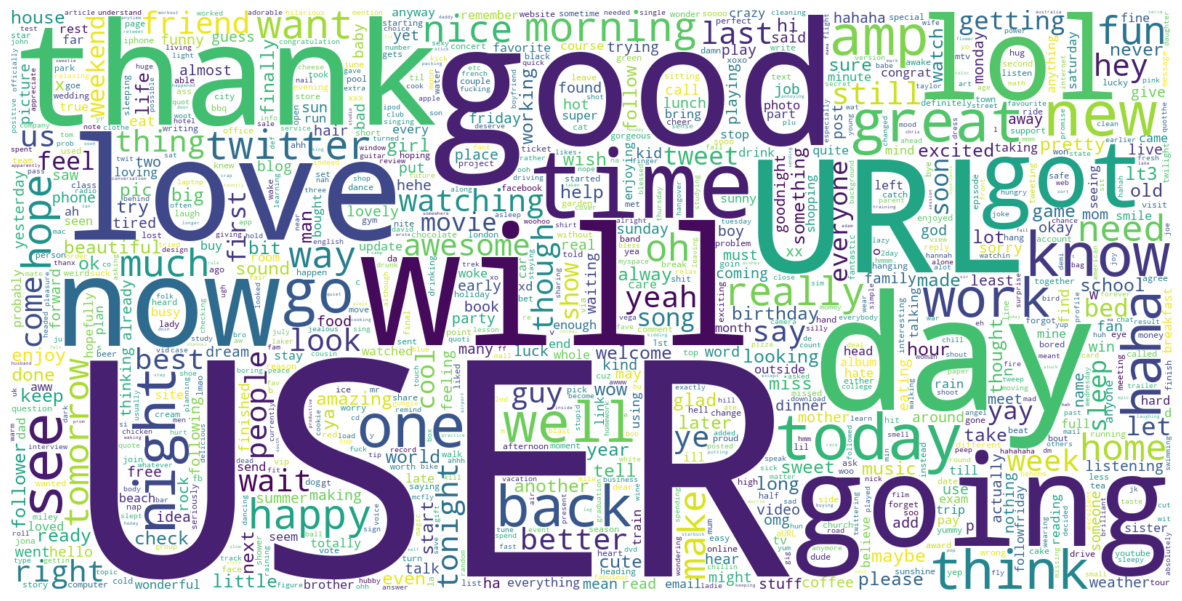

In [42]:
# create a word cloud for positive and negative tweets
from wordcloud import WordCloud

def plot_wordcloud(data, color='black'):
    wordcloud = WordCloud(background_color=color, max_words=1000, width=1600, height=800, random_state=42, collocations=False).generate(" ".join(data))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud(data_pos, 'white')

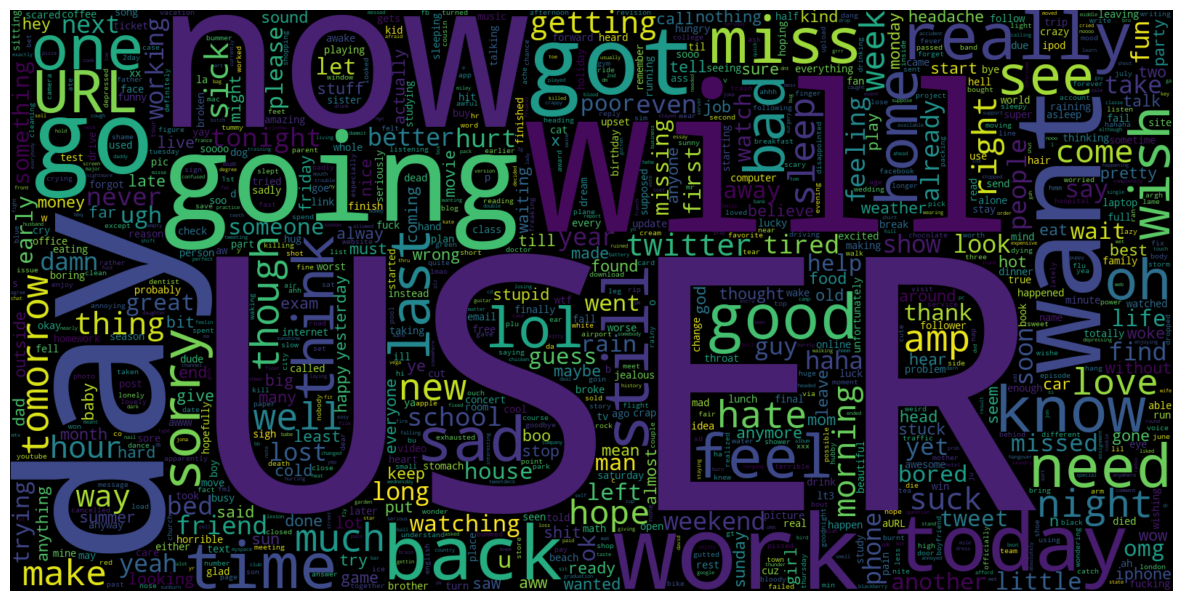

In [43]:
plot_wordcloud(data_neg)

In [46]:
# find the max length of a tweet

max_len = max([len(s.split()) for s in df['processed_text']])
print('Max length of a tweet: ', max_len)

Max length of a tweet:  41


In [47]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df['processed_text'].values
y = df['sentiment'].values

MAX_LEN = 140 # as this was the max length of a tweet back in the day
VOCAB_SIZE = 10000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>', lower=False)
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index) if VOCAB_SIZE > len(word_index) else VOCAB_SIZE
top_words = min((len(word_index), VOCAB_SIZE))
print('Found %s unique tokens. Distilled to %s.' % (len(word_index), top_words))

X = pad_sequences(sequences, maxlen=MAX_LEN)
y_ohe = keras.utils.to_categorical(y, 2)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)

Found 437422 unique tokens. Distilled to 10000.
Shape of data tensor: (1600000, 140)
Shape of label tensor: (1600000, 2)
CPU times: user 25 s, sys: 646 ms, total: 25.7 s
Wall time: 25.8 s


### Splitting the Data

In [ ]:
from sklearn.model_selection import train_test_split

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe,test_size=0.2, random_state=42)